# LMS Exploration | 7. Sentimental_NLP

---


```
오늘은 불금.
일주일 내내 개미처럼 일만 했으니, 오늘은 나에게 포상을 줘야겠다.
시원달달한 수박을 먹으면서 영화 한편을 보고 싶은데, 
어떤 영화를 볼지 고민이 된다.

아..? 리뷰 댓글이 가장 많이 달린 영화가 마침 평점기능에 에러가 났다..
너무너무 재밌어서 평점이 폭발해버린걸까?
리뷰 댓글을 하나하나 읽기엔 리뷰가 너무 많고,
궁금한건 못참겠다.
나에게 왜 이런 시련과 고난이 닥친걸까..

안되겠다.

이 영화의 리뷰댓글을 분석해서 평점을 추측할 수 있도록 
감정분석 모델을 만들어야겠다.
```
---

**[Introduce]**  
다양한 딥러닝 모델을 활용하여 영화리뷰댓글의 감정분석을 해보자.  
이후 Word2Vec을 이용하여 성능향상을 시도해보자


**[[Data](https://github.com/e9t/nsmc)]**
* [네이버 영화](https://movie.naver.com/movie/point/af/list.naver)의 댓글을 모아 구성된 Naver Sentiment Movie Corpus (NSMC)


* NSMC는 150000개의 훈련데이터셋, 50000개의 테스트데이터셋으로 구성된다. 


* NSMC 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이뤄진다.


* 훈련데이터셋의 컬럼은 id, document, label이다.  


    -id : 댓글 작성자의 고유번호 (the review id)  
    -document : 감정분석의 대상인 리뷰 텍스트 (the actual review)  
    -label : 각각의 문장에 대응하는 감정을 원핫인코딩한 것으로, 긍정일 경우 1, 부정 경우 0으로 표현됨. (the sentiment class of the review-> 0:negative, 1:positive)  

* 모든 리뷰는 140자 미만이다.
* 각 sentiment class (0:negatice, 1:positive)의 비율은 동등하게 구성했다.

    -100K negative reviews (reviews of rating 1-4)  
    -100K positive review (reviews of rating 9-10)  
    -Neutral review ( reveiws of rating 5-8)은 제외했음  

**[Preparation]**

* NSMC 파일 업로드
* genism 버전 다운그레이드 - Word2Vec을 사용하려면 다운그레이드가 필요함. 
```
gensim 4.0.1 -> genisim 3.8.3
```

In [1]:
! ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_train.txt': File exists


```
#- gensim downgrade

root@w3wkht8atotw0zzxqge0w24qf-6f78dfd478-tf8bl:~# pip install --upgrade gensim==3.8.3
```

---



# 0. Import Library, Package

In [2]:
%%time
import os
import urllib.request
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from konlpy.tag import Okt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

from keras.layers import Bidirectional, LSTM, GRU, Dense, Conv1D
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from gensim.models import KeyedVectors
import gensim
from sklearn.model_selection import train_test_split

from collections import Counter



CPU times: user 2.67 s, sys: 717 ms, total: 3.39 s
Wall time: 2.45 s


# 1. 데이터 준비와 확인

In [3]:
#- 데이터 읽어오기

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [4]:
#- 데이터 개수 확인하기

print(len(train_data),len(test_data))
train_data.columns

150000 50000


Index(['id', 'document', 'label'], dtype='object')

In [5]:
#- 데이터 확인하기

train_data.head() 

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


```
train_data.head() 데이터 확인 결과,. 

* 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 -> 1(긍정)
* 너무재밓었다그래서보는것을추천한다 -> 0(부정)

위 두 문장의 라벨링을 보고 공감이 되지 않아서 데이터에 대한 의문이 생겼다.
'너무'가 과거엔 부정적 의미로 해석되었기 때문일까? '너무' 단어를 가진 문장 뽑아서 살펴봐야겠다.
```

---
```
잘못 라벨링되었다고 판단하여 변경하려 했지만, NSMC 의 라벨링 방법을 살펴보니, originally reviews of ratings 즉 평점으로 라벨링한다고 하여, 본래 라벨링을 따르기로 했다. 
문장의 반어적 표현, 애매한 표현에 대한 감정 평가는 평점으로 판단하는 것이 적절할 것이다.
```


```python
#- 라벨 변경

train_data.iloc[1,2]=0
train_data.iloc[2,2]=1

train_data.head()

#- '너무'가 포함된 문장 추출

neomu = []

for i, j in enumerate(X_train):
    if 24 in j:
        neomu.append(j)

neomu = get_decoded_sentences(neomu, index_to_word)
neomu
```

# 2. 데이터로더 구성
```
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전`word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴
```

---


* [drop_duplicates](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)
```
Return DataFrame with duplicate rows removed.
subset : column label or sequence of labels, optional
    Only consider certain columns for identifying duplicates, by default use all of the columns.
```    
* [train_data.dropna](https://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.DataFrame.dropna.html)
```
how : {‘any’, ‘all’}
    any : if any NA values are present, drop that label
    all : if all values are NA, drop that label
```


* [mecab-ko-dic](https://konlpy-ko.readthedocs.io/ko/v0.4.3/api/konlpy.tag/)  
``` 
mecab-ko-dic은 오픈 소스 형태소 분석 엔진인 MeCab을 사용하여, 한국어 형태소 분석을 하기 위한 프로젝트임. 말뭉치 학습과 사전 목록은 모두 21세기 세종계획의 성과물을 사용함.   
```

* [konlpy.tag](https://konlpy-ko.readthedocs.io/ko/v0.4.3/api/konlpy.tag/)
```
morphs(phrase)
    Parse phrase to morphemes.
nouns(phrase)
    Noun extractor.
pos(phrase, flatten=True)
    POS tagger.
```

* [collections.Counter](https://docs.python.org/3/library/collections.html#collections.Counter)
```
A Counter is a dict subclass for counting hashable objects. It is a collection where elements are stored as dictionary keys and their counts are stored as dictionary values.
```
```python
most_common([n])
Return a list of the n most common elements and their counts from the most common to the least. 
```

In [6]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    #- 데이터의 중복 제거, NaN 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    #- 토큰화, 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-5) #- 데이터 개수가 많은 순으로 정렬된 배열 리턴
    vocab = ['', '', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} #- word : index 사전
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index 

In [7]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [8]:
print("데이터 중복, 결측치, 불용어 제거의 결과,\n훈련 샘플 개수: {}, 테스트 개수: {}\n".format(len(X_train), len(X_test)))

데이터 중복, 결측치, 불용어 제거의 결과,
훈련 샘플 개수: 146182, 테스트 개수: 49157



In [9]:
for i in range(5):
    print(f'[{i}번째 리뷰 문장]\n{X_train[i]}\n길이 : {len(X_train[i])}\n라벨 : {y_train[i]}\n')

[0번째 리뷰 문장]
[33, 75, 920, 5, 5, 40, 229, 21, 34, 749]
길이 : 10
라벨 : 0

[1번째 리뷰 문장]
[1029, 5, 12, 520, 550, 688, 6, 121, 5, 71, 1640, 53, 926, 1007, 16, 45, 392]
길이 : 17
라벨 : 1

[2번째 리뷰 문장]
[25, 206, 4]
길이 : 3
라벨 : 0

[3번째 리뷰 문장]
[8410, 159, 3926, 5, 5, 299, 95, 18, 7, 5, 5, 59, 3480]
길이 : 13
라벨 : 0

[4번째 리뷰 문장]
[4, 8895, 1109, 53, 2833, 61, 6, 15, 2759, 42, 1189, 36, 352, 43, 23, 41, 61, 4, 4, 428, 3103, 1767, 7]
길이 : 23
라벨 : 1



텍스트 데이터가 숫자로 encoding이 잘 되었음을 확인할 수 있음!

[pprint](https://docs.python.org/ko/3/library/pprint.html)를 이용해서 word_to_index 단어사전에 어떤 단어들이 포함되어있는지 보기 좋게 출력하여 살펴보자. 
(특수문자-영어-한글(가나다 순)으로 정렬)

```python
import pprint

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(word_to_index)
```

특수문자의 경우, 감정을 드러내는 중요한 의미를 담고 있을 수 있기 때문에, 제거하지 않았다. 다만 숫자의 경우 검토해볼 필요가 있다.   
불금이 지나가고 있으므로 일단 skip~

```python
number = re.compile('[0-9]+')
number_dict = {}
for i,j in word_to_index.items():
    if number.match(i):
        number_dict[i]=j

number_dict
```

**[Special_tokens]**   
언어모델의 범용성을 위해 Dummy token인 UNK, UNUSED를 여러개 설정해줘야 한다. 또한 BOS(문장시작), EOS(문장 끝)도 추가한다.

이번 NSMC 학습에서는 PAD, BOS, UNK, UNUSED를 각 하나씩 단어사전에 더해주었다.

In [11]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

In [12]:
#- word_to_index를 index_to_word로 변환
index_to_word = {index:word for word, index in word_to_index.items()}

### 문장 인코더, 디코더

In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:]) 
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델구성을 위한 데이터 분석 및 가공

자연어처리(NLP)분야에서 **임베딩(Embedding)** 은 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자형태인 vector로 바꾼 결과 혹은 그 일련의 과정 전체를 의미한다. 가장 간단한 형태의 임베딩은 단어의 빈도를 그대로 벡터로 사용하는 것이다.  

앞선 encoding 작업을 통해 텍스트가 숫자로 변환되어 인공지능 모델의 입력으로 사용할 수 있게 되었지만, 이것으로는 충분치 않다! 단어와 숫자의 의미없는 대응이기 때문이다.

**우리의 목적은, 단어와 그 단어의 의미를 나타내는 벡터를 짝짓는 것!** 으로, 단어의 의미를 나타내는 벡터를 훈련 가능한 파라미터로 놓고, 이를 딥러닝을 통해 최적화해야 한다. 비슷한 분포를 가진 단어의 주변 단어들도 비슷한 의미를 가진다는 아이디어를 기반으로 하는 단어임베딩을 수행해보자.
 

이때, embedding을 위해서는 pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일해야 한다. 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게되므로,
전체 데이터셋 내의 문장 길이의 분포를 파악하여 적절한 최대 문장 길이를 지정해야 한다.

 * 데이터셋 내 문장 길이 분포
 * 적절한 최대 문장 길이 지정
 * keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [14]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


## Padding
한글은 문장 뒷부분에 핵심 내용이 포함되기 때문에 padding의 위치를 'pre'로 설정했다.    
(한국말은 끝까지 들으라는 유명한 말 있잖아요~) 

In [15]:
x_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='pre', # 혹은 'post'
                        maxlen=maxlen)

x_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='pre', # 혹은 'post'
                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


# 4. 모델구성 및 validation set 구성

4가지 모델을 이용하여 성능 비교

1. LSTM
2. Bidirectional LSTM
3. GRU
4. CNN


## validation set 

In [16]:
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=814)

In [17]:
print(partial_x_train.shape, x_val.shape, partial_y_train.shape, y_val.shape)

(116945, 41) (29237, 41) (116945,) (29237,)


## embedding hyperparameter

```python
tf.keras.layers.Embedding(
    input_dim, output_dim, embeddings_initializer='uniform',
    embeddings_regularizer=None, activity_regularizer=None,
    embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
)
```

In [18]:
vocab_size = len(word_to_index) #- 어휘 사전의 크기
word_vector_dim = 256 #- 단어 하나를 표현하는 임베딩 벡터의 차원 수

print(vocab_size, word_vector_dim)

10000 256


## Model

### 1. LSTM(Long Short Term Memory)

In [19]:
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(keras.layers.LSTM(32))   
model_lstm.add(keras.layers.Dense(8, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid')) 

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                36992     
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,597,265
Trainable params: 2,597,265
Non-trainable params: 0
_________________________________________________________________


### 2. Bidirectional LSTM 

In [21]:
model_blstm = keras.Sequential()
model_blstm.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_blstm.add(Dropout(0.5))
model_blstm.add(LSTM(256, return_sequences=True))
model_blstm.add(Dropout(0.5))
model_blstm.add(Bidirectional(LSTM(256, return_sequences=True)))
model_blstm.add(Dropout(0.5))
model_blstm.add(Dense(1, activation='sigmoid'))
          
model_blstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1050624   
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)          

### 3. GRU ( Gated Recurrent Units )



In [23]:
model_gru = keras.Sequential()
model_gru.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gru.add(GRU(256, activation='relu'))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
gru (GRU)                    (None, 256)               394752    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,955,009
Trainable params: 2,955,009
Non-trainable params: 0
_________________________________________________________________


### 4. CNN (Convolutional Neural Network)


In [24]:
model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          28688     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

# 5. 모델 훈련

In [26]:
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_blstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)
print('LSTM')
history_blstm = model_blstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)
print('Bidirectional LSTM')
history_gru = model_gru.fit(partial_x_train,
                    partial_y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)
print('GRU')
history_cnn = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)
print('CNN')


Epoch 1/15
914/914 [==============================] - 21s 21ms/step - loss: 0.5376 - accuracy: 0.7561 - val_loss: 0.4110 - val_accuracy: 0.8474
Epoch 2/15
914/914 [==============================] - 18s 20ms/step - loss: 0.3665 - accuracy: 0.8714 - val_loss: 0.3593 - val_accuracy: 0.8571
Epoch 3/15
914/914 [==============================] - 18s 19ms/step - loss: 0.2889 - accuracy: 0.8996 - val_loss: 0.3482 - val_accuracy: 0.8576
Epoch 4/15
914/914 [==============================] - 18s 19ms/step - loss: 0.2405 - accuracy: 0.9170 - val_loss: 0.3624 - val_accuracy: 0.8585
Epoch 5/15
914/914 [==============================] - 18s 19ms/step - loss: 0.2014 - accuracy: 0.9319 - val_loss: 0.3931 - val_accuracy: 0.8535
Epoch 6/15
914/914 [==============================] - 17s 19ms/step - loss: 0.1697 - accuracy: 0.9440 - val_loss: 0.4108 - val_accuracy: 0.8522
Epoch 00006: early stopping
LSTM
Epoch 1/15
914/914 [==============================] - 90s 94ms/step - loss: 0.4750 - accuracy: 0.7578 -

# 6. Loss, Accuracy 그래프 시각화

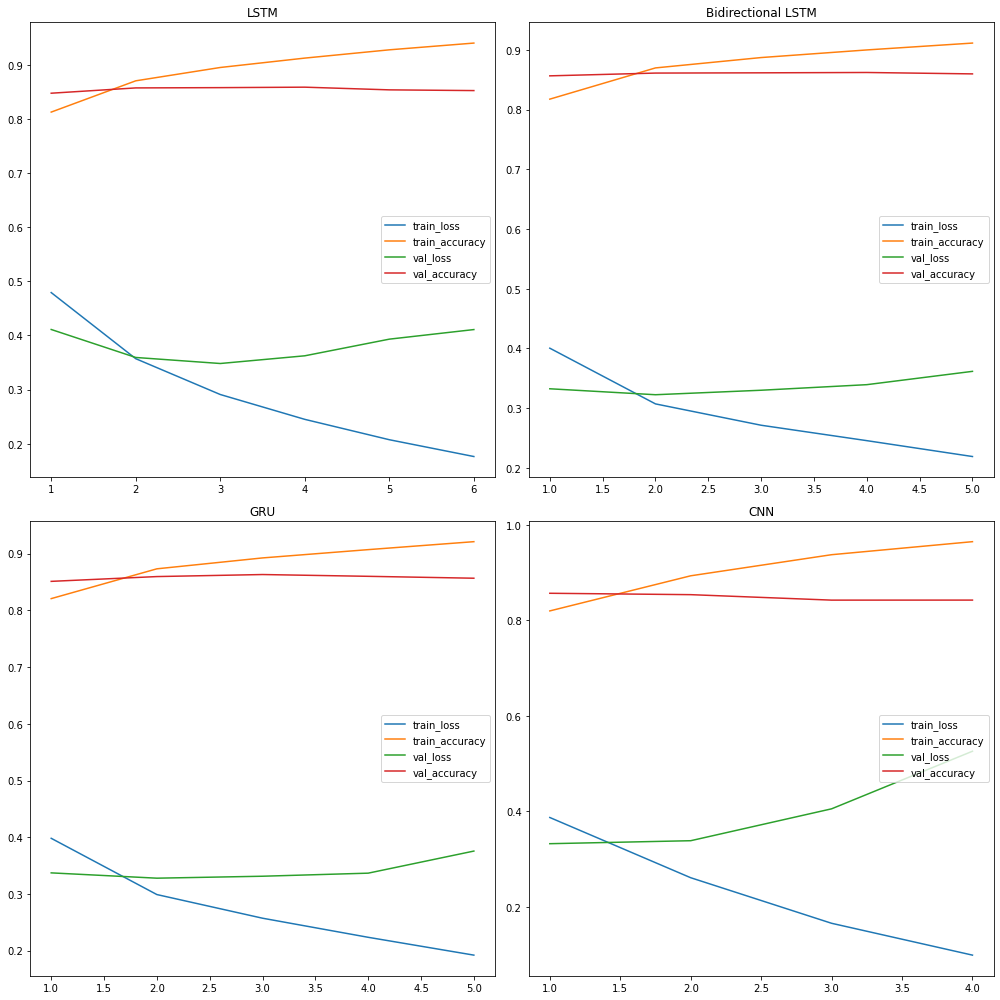

In [31]:
def plot_history(history_dict):
    train_acc = history_dict['accuracy']
    train_loss = history_dict['loss']
    val_acc = history_dict['val_accuracy']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, train_acc)
    plt.plot(epochs, val_loss)
    plt.plot(epochs, val_acc)
    plt.legend(['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'],loc='center right')
    

history_lstm_dict = history_lstm.history
history_blstm_dict = history_blstm.history
history_gru_dict = history_gru.history
history_cnn_dict = history_cnn.history

plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
plot_history(history_lstm_dict)
plt.title('LSTM')

plt.subplot(2,2,2)
plot_history(history_blstm_dict)
plt.title('Bidirectional LSTM')

plt.subplot(2,2,3) 
plot_history(history_gru_dict)
plt.title('GRU')

plt.subplot(2,2,4) 
plot_history(history_cnn_dict)
plt.title('CNN')

plt.tight_layout()
plt.show()

# 7. 학습된 Embedding 레이어 분석

In [34]:
lstm_loss, lstm_acc = model_lstm.evaluate(x_test, y_test, verbose=2)
blstm_loss, blstm_acc = model_blstm.evaluate(x_test, y_test, verbose=2)
gru_loss, gru_acc = model_gru.evaluate(x_test, y_test, verbose=2)
cnn_loss, cnn_acc = model_cnn.evaluate(x_test, y_test, verbose=2)

1537/1537 - 5s - loss: 0.4146 - accuracy: 0.8512
1537/1537 - 21s - loss: 0.3631 - accuracy: 0.8598
1537/1537 - 13s - loss: 0.3794 - accuracy: 0.8536
1537/1537 - 3s - loss: 0.5263 - accuracy: 0.8407


In [36]:
df_loss = pd.DataFrame({'Model' : ['LSTM', 'Bi_LSTM','GRU', 'CNN'], 
                        'Loss' : [lstm_loss, blstm_loss, gru_loss, cnn_loss]})
df_acc = pd.DataFrame({'Model' : ['LSTM', 'Bi_LSTM', 'GRU', 'CNN'], 
                        'Accuracy' : [lstm_acc, blstm_acc, gru_acc, cnn_acc]})

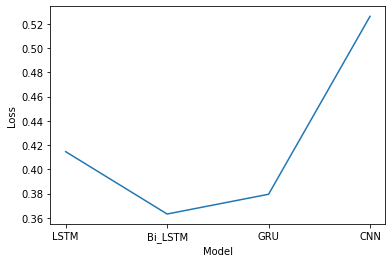

In [38]:
loss_plot= sns.lineplot(x='Model', y='Loss', data=df_loss)

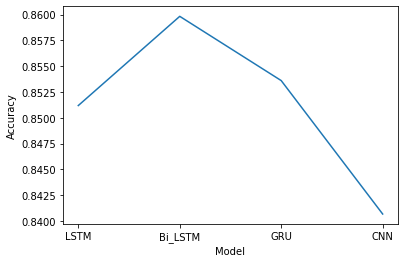

In [37]:
acc_plot= sns.lineplot(x='Model', y='Accuracy', data=df_acc)

```
Bidirectional LSTM이 4가지 모델 중에서 가장 좋은 성능을 보인다. 
loss: 0.3631 
accuracy: 0.8598

한국어 Word2Vec pretrained 모델을 사용하지 않았음에도 정확도 0.85를 넘었다. 
하지만 6.loss, accuracy 시각화 그래프를 살펴보면, 4가지 모델 모두 epoch 2 에서부터 train_loss는 감소하지만 val_loss는 증가하는 것이 보인다. 1 epoch에서부터 비교적 높은 train, val accuracy(약 0.8)를 보이고, train_accuracy는 점차 0.9에 다다르지만, val_accuracy는 증가하지 않는다. 이는 overfitting으로 인한 현상으로 보인다.    

```

# 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

[한국어Word2Vec](https://github.com/Kyubyong/wordvectors)을 활용하여 영화리뷰 감정분석모델의 성능을 향상시켜보자 :-)

모델비교에서 성능이 가장 좋았던 **Bidirectional LSTM 모델**로 학습해보고,  
한국어 Word2Vec 사용 전후 결과를 비교해보자!

---
```
Word2Vec은 구글에서 제공하는 사전학습된(pretrained)워드 임베딩 모델으로,
무려 1억 개의 단어로 구성된 Google News dataset을 바탕으로 학습되었다.
기존의 원핫인코딩이나 TF-IDF의 경우 단어의 의미를 고려하지 못하는 단점을 해결한 방법으로, 
중심 단어와 주변 단어 간의 관계를 통해서 임베딩 하는 기법을 사용한다.

특정 문제를 풀기 위해 학습한 모델을 다른 문제 해결에 재사용하는 기법을 전이학습이라고 한다. 
광범위한 데이터를 통해 미리 학습해 놓은 임베딩 속에 녹아 있는 의미, 문법 등의 부가적 정보를 
내가 만들려는 모델이 활용할 수 있는 피처로 활용한다면 더욱 빠르고 정확하게 학습할 수 있다.
```
    
   



In [40]:
#- 한국어 Word2Vec의 정보

ko_Word2Vec = {'Language':'korean', 'ISO 639-1':'ko','Vector_Size':'200', 'Corpus Size':'339M','Vocabulary Size':'30185'}

ko_Word2Vec = pd.Series(ko_Word2Vec)
ko_Word2Vec

Language           korean
ISO 639-1              ko
Vector_Size           200
Corpus Size          339M
Vocabulary Size     30185
dtype: object

In [42]:
#- 사전학습된 Word2Vec 불러오기

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [43]:
#- Word2Vec으로 Embedding Matrix 만들기

vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [46]:
#- 모델 구성
#- 위에서 가장 성능이 좋았던 Bidirectional LSTM 사용!

model= keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True)) 
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [47]:
#- 모델 훈련

partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=814)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15   

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
914/914 [==============================] - 87s 91ms/step - loss: 0.5724 - accuracy: 0.6870 - val_loss: 0.3584 - val_accuracy: 0.8419
Epoch 2/15
914/914 [==============================] - 83s 90ms/step - loss: 0.3818 - accuracy: 0.8296 - val_loss: 0.3246 - val_accuracy: 0.8598
Epoch 3/15
914/914 [==============================] - 80s 87ms/step - loss: 0.3359 - accuracy: 0.8524 - val_loss: 0.3167 - val_accuracy: 0.8652
Epoch 4/15
914/914 [==============================] - 79s 86ms/step - loss: 0.3104 - accuracy: 0.8668 - val_loss: 0.3110 - val_accuracy: 0.8664
Epoch 5/15
914/914 [==============================] - 78s 85ms/step - loss: 0.2940 - accuracy: 0.8753 - val_loss: 0.3028 - val_accuracy: 0.8716
Epoch 6/15
914/914 [==============================] - 79s 87ms/step - loss: 0.2800 - accuracy: 0.8807 - val_loss: 0.3106 - val_accuracy: 0.8695
Epoch 7/15
914/914 [==============================] - 75s 82ms/step - loss: 0.2689 - accuracy: 0.8870 - val_loss: 0.3215 - val_accuracy:

In [48]:
#- 모델 훈련 (callbacks=[early_stopping])

history_cb = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/15
914/914 [==============================] - 77s 85ms/step - loss: 0.2082 - accuracy: 0.9150 - val_loss: 0.3436 - val_accuracy: 0.8734
Epoch 2/15
914/914 [==============================] - 77s 84ms/step - loss: 0.2045 - accuracy: 0.9156 - val_loss: 0.3468 - val_accuracy: 0.8732
Epoch 3/15
914/914 [==============================] - 77s 85ms/step - loss: 0.1996 - accuracy: 0.9178 - val_loss: 0.3453 - val_accuracy: 0.8717
Epoch 4/15
914/914 [==============================] - 77s 84ms/step - loss: 0.1946 - accuracy: 0.9200 - val_loss: 0.3655 - val_accuracy: 0.8729
Epoch 00004: early stopping


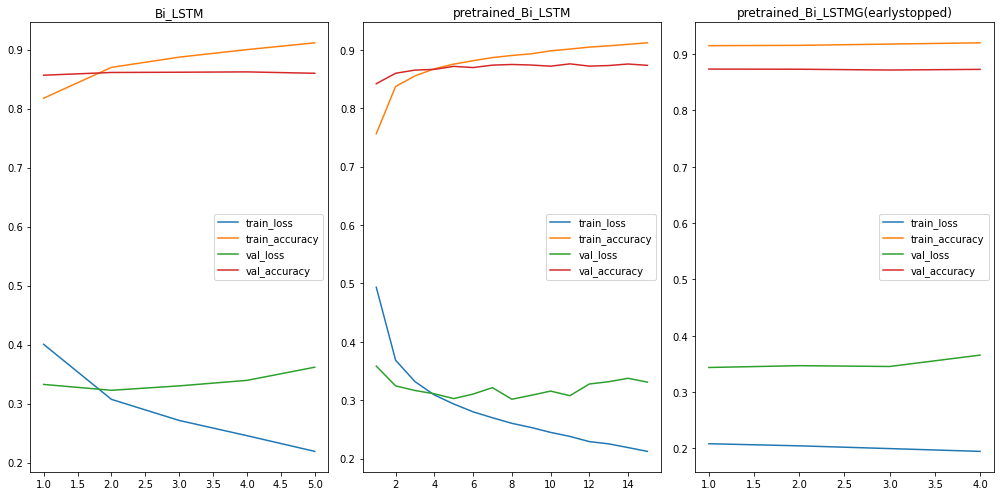

In [54]:
history_dict = history.history
history_cb_dict = history_cb.history
history_blstm_dict = history_blstm.history
plt.figure(figsize=(14,7))

plt.subplot(131)
plot_history(history_blstm_dict)
plt.title('Bi_LSTM')

plt.subplot(132)
plot_history(history_dict)
plt.title('pretrained_Bi_LSTM')

plt.subplot(133) 
plot_history(history_cb_dict)
plt.title('pretrained_Bi_LSTMG(earlystopped)')


plt.tight_layout()
plt.show()

In [50]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)

1537/1537 - 21s - loss: 0.3624 - accuracy: 0.8727


In [51]:
df_loss = pd.DataFrame({'Model' : ['Bi_LSTM','pretrained_Bi_LSTM'], 
                        'Loss' : [blstm_loss, loss]})
df_acc = pd.DataFrame({'Model' : ['Bi_LSTM','pretrained_Bi_LSTM'], 
                        'Accuracy' : [blstm_acc, acc]})

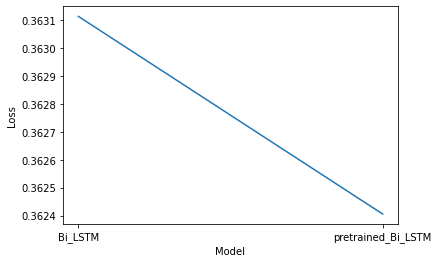

In [52]:
loss_plot= sns.lineplot(x='Model', y='Loss', data=df_loss)

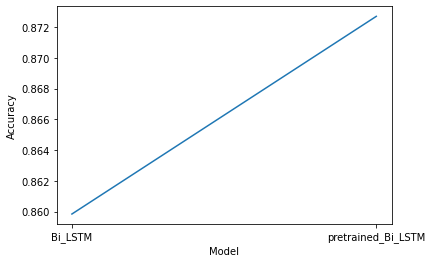

In [53]:
acc_plot= sns.lineplot(x='Model', y='Accuracy', data=df_acc)

## Embedding 모델 학습 결과 비교

```
pretrained 한국어Word2Vec 모델을 사용하지 않았던 Bi_LSTM 모델, earlystopping 인자를 설정한 pretrained_BI_LSTM 을 비교했을 때,  
훈련과정에서 train_loss, train_acc 가 단시간에 매우 좋은 결과를 보였지만, 
val_loss, val_acc 는 기존모델과 큰 차이가 없었다.

하지만 결과적으로 Pretrained 된 한국어 Word2Vec 임베딩모델을 활용했을 때 성능이 약간 향상됐다.  

test_loss: 0.3624 (기존 0.3631)
test_accuracy: 0.8727 (기존 0.8598)

```

---

```
영화리뷰 감정분석기의 이 정도 성능이면, 평점 없이도 영화가 볼만한지 어느정도는 예측할 수 있을 것 같다. 
과연 이 영화는 인기때문에 평점이 폭발했던 것일까????


다음번에는 영화 추천 모델을 만들어볼까????
```